## <span style="color:#008891">Description of survey results: temporal, geopgraphic and administrative scope</span>

#### <span style="color:#008891">Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes</span>

The summary of the survey results and survey characteristics is provided. The results are presented nationally and by river bassin for all surveys since April 1, 2020. The dates and river basins can be modified by the user. For now this function only works on data later than January 1st 2020. The dimensional data from prior projects will be integrated in the future.

There are several variables that are loaded by default:

1. code group designations
2. river bassin labels

These variables can be changed in the notebook or a .JSON object can be loaded to replace the defaults. Currently this notebook provides an easy path to aggregating down to the municipal level. To provide a report for one location use the location summary notebook.


#### <span style="color:#008891">Contents</span>

A summary of the number of locations and the effected population as well as an exhaustive list of lakes, rivers and municipalites where surveys were conducted.

The survey data for the time frame labeled with the approriate code group and river bassin labels.

The dimensional records are matched to the survey records, missing records are identified and records that do not have a match in both data sets are excluded. The list of excluded surveys and the percentage of all the surveys that are being used to calculate the summary is provided.

The dimensional records are summarized to the catchement area.

Figure 1-5 relationship of "number of items found per survey" to the following measurements:

1. Time to complete a survey
2. Total weight
3. Weight of plastics > 5mm
4. Length of survey
5. Surface area

#### <span style="color:#008891">Output*</span>

1. A .csv file of all the survey records used
2. A .csv file of all the dimensional data used
3. Figure 1-5
4. A .JSON directory object for use in other scripts

\*To include html output use the following command in the terminal to produce the file:

> _jupyter-nbconvert --to html --TemplateExporter.exclude_input=True --no-prompt project_description.ipynb --template classic_

> _more information https://nbconvert.readthedocs.io/en/latest/_

This will produce an .HTML version of this document without the code, like the example in the example folder

#### <span style="color:#008891">More information </span>

For information on a specific catchment area or a water feature see the notebook for that catchment area (or make one and send a pull request). For more information on the project visit https://www.plagespropres.ch/ .

This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}

# easy variables to the directory tree
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

today = dt.datetime.now().date().strftime("%Y-%m-%d")

# set some parameters:
start_date = '2020-04-01'
end_date =today

# name the folder:
name_of_project = 'projectdescription'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# kwargs for the abundance class
group_names_locations = ut.json_file_get(F"{output}/code_groups/code_group2.json")

# convenience method to organize output
def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [2]:
# get data

# see the notebook "getdataforrepo" to better understand the process up to this point
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# river bassin labels
river_bassins = ut.json_file_get(F"{location_data}/river_basins.json")

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)

# assign river bassin labels to locations:
for k,v in river_bassins.items():
    dfBeaches.loc[dfBeaches.water_name_slug.isin(v), 'river_bassin'] = k

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# dimensional data
dfDims = pd.read_csv(F"{survey_data}/dims_data.csv")
# the loc date key needs updating:
dfDims['loc_date'] = list(zip(dfDims.location, dfDims.date))

# project lakes and beaches:
project_lakes = ut.json_file_get(F"{location_data}/project_lakes.json")
project_beaches = ut.json_file_get(F"{location_data}/project_beaches.json")

# make a copy of the survey data and tag the records as either lake or river:
data = dfSurveys.copy()

# columns can be added to the data before prcessing it
# the kwarg these_columns is an array of column names to be kept

# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name_slug.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name_slug.unique()

# tagging each record as either lake or river:
# map values to new column t:
data['type'] = 't'
for a_place in data.water_name_slug.unique():
    data.loc[data.water_name_slug.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name_slug.isin(rivers), 'type'] = 'r'

# check if there are any un categorized records:
if len(data[data['type']=='t']) > 0:
    print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")
else:
    pass

# put the data into a class
# kwargs for the data class
a_class_kwargs = dict(
    code_group_data=group_names_locations,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],
    code_group_loc=output,
)

# this puts the data into an abundance class
# type help(ac.abundance)
a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)

# define the final data set here:
# in this report we are exlcuding all records from the reuss river basin
a_data = a.survey_data[a.survey_data.river_bassin != 'reuss'].copy()

# describe the data set:
num_obs = len(a_data)
num_samps = len(a_data.loc_date.unique())
num_obj = a_data.quantity.sum()
num_locs = len(a_data.location.unique())
num_rivs = a_data[a_data['type']=='r'].water_name_slug.nunique()
num_lakes = a_data[a_data['type'] == 'l'].water_name_slug.nunique()

# number of municipalities
a_map = dfBeaches['city']
munis = [a_map[x] for x in a_data.location.unique()]
munis = list(set(munis))
num_munis = len(munis)

# population
total_pop_d = dfBeaches.loc[a_data.location.unique()][['city', 'population']]
total_pop_c = total_pop_d.drop_duplicates('city')
total_pop = total_pop_c.population.sum()

In [3]:
a_data

,date,code,pcs_m,quantity,location,loc_date,water_name_slug,type,groupname,population,buildings,streets,intersects,pop_group_proj,pop_group_rip,streets_rank,buildings_rank,string_date,river_bassin
0,2021-04-17,G31,0.04,2,limmat_dietikon_keiserp,"(limmat_dietikon_keiserp, 2021-04-17)",limmat,r,food,27265.0,832955.73,130249.17,0.0,no_data,14.0,3.0,3.0,2021-04-17,linth
1,2021-04-17,G154,0.04,2,limmat_dietikon_keiserp,"(limmat_dietikon_keiserp, 2021-04-17)",limmat,r,personal items,27265.0,832955.73,130249.17,0.0,no_data,14.0,3.0,3.0,2021-04-17,linth
2,2021-04-17,G200,0.12,6,limmat_dietikon_keiserp,"(limmat_dietikon_keiserp, 2021-04-17)",limmat,r,food,27265.0,832955.73,130249.17,0.0,no_data,14.0,3.0,3.0,2021-04-17,linth
3,2021-04-17,G30,0.02,1,limmat_dietikon_keiserp,"(limmat_dietikon_keiserp, 2021-04-17)",limmat,r,food,27265.0,832955.73,130249.17,0.0,no_data,14.0,3.0,3.0,2021-04-17,linth
4,2021-04-17,G198,0.02,1,limmat_dietikon_keiserp,"(limmat_dietikon_keiserp, 2021-04-17)",limmat,r,not classified,27265.0,832955.73,130249.17,0.0,no_data,14.0,3.0,3.0,2021-04-17,linth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2020-10-13,G74,0.00,0,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2020-10-13)",zurichsee,l,construction,415367.0,549380.04,94616.14,2.0,1.0,1.0,3.0,3.0,2020-10-13,linth
355,2020-11-12,G74,0.00,0,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2020-11-12)",zurichsee,l,construction,415367.0,549380.04,94616.14,2.0,1.0,1.0,3.0,3.0,2020-11-12,linth
356,2020-12-10,G74,0.00,0,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2020-12-10)",zurichsee,l,construction,415367.0,549380.04,94616.14,2.0,1.0,1.0,3.0,3.0,2020-12-10,linth
357,2021-01-10,G74,0.00,0,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2021-01-10)",zurichsee,l,construction,415367.0,549380.04,94616.14,2.0,1.0,1.0,3.0,3.0,2021-01-10,linth


### <span style="color:#008891"> Effective dates, river bassins, number of obervations, number of surveys and number of objects</span>

In [4]:
print(F"\nThis data is valid for surveys surveys between {start_date} and {end_date} from the following catchment areas:\n\n  {a_data.river_bassin.unique()}")

print(F"\nThere are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected.")


This data is valid for surveys surveys between 2020-04-01 and 2021-04-23 from the following catchment areas:

  ['linth' 'aare' 'rhone' 'ticino' nan]

There are 77,571 observations from 351 surveys.

There were 50,944 objects collected.


In [5]:

print(F"\nThere are {num_locs} different survey locations from {num_munis} municipalities with a total population of ~{'{:,}'.format(total_pop)}")
print(F"\nThere are samples from {num_lakes} different lakes and {num_rivs} different rivers.\n")

print(F"\nThe lakes where the surveys were conducted:\n\n{a_data[a_data['type'] == 'l'].water_name_slug.unique()}\n")

print(F"\nThe rivers where the surveys were conducted:\n\n{a_data[a_data['type'] == 'r'].water_name_slug.unique()}\n")

print(F"\nThe municpalities where the surveys were conducted:\n\n{munis}\n")


There are 122 different survey locations from 68 municipalities with a total population of ~1,603,067

There are samples from 8 different lakes and 14 different rivers.


The lakes where the surveys were conducted:

['neuenburgersee' 'lac-leman' 'thunersee' 'bielersee' 'walensee'
 'zurichsee' 'lago-maggiore' 'brienzersee']


The rivers where the surveys were conducted:

['limmat' 'sihl' 'ticino' 'aare' 'rhone' 'schuss' 'jona' 'linthkanal'
 'maggia' 'la-thiele' 'aarenidau-buren-kanal' 'dorfbach' 'escherkanal'
 'seez']


The municpalities where the surveys were conducted:

['Saint-Gingolph', 'Ligerz', 'Ascona', 'Gals', 'La Tour-de-Peilz', 'Boudry', 'Cheyres-Châbles', 'Bönigen', 'Genève', 'Yverdon-les-Bains', 'Spiez', 'Versoix', 'Le Landeron', 'Solothurn', 'Hauterive (NE)', 'Nidau', 'Dietikon', 'Lavey-Morcles', 'Stäfa', 'Leuk', 'Gambarogno', 'Bellinzona', 'Brienz (BE)', 'Rapperswil-Jona', 'Zürich', 'Préverenges', 'Freienbach', 'Bern', 'Schmerikon', 'Riddes', 'Lausanne', 'Kallnach', 'Minu

## <span style="color:#008891">The dimensional data summary</span>

### <span style="color:#008891"> Match the dimensional records to the survey records</span>

#### There are two components to a survey:

1. The objects that are found
2. The context in which they were found -- dimensional data

These two elements are transmitted seperately when the surveyor submits the data. The main reason for this is efficiency and speed. The context for each survey is unique and each survey can generate up to 220 observations in the same context.

Before analysis the dimensional data records need to be matched up to the survey data. The *loc_date* key is the unique indentifier for each survey. Here we match up the loc_date keys from both data sets.

Dimensional data with no matching survey is dropped. An inquiry is made to the surveyor to identify the nature of the discrepancy. Missing dimensional data can be recuperated by asking the surveyor. There are paper records generated at each survey. Records are dropped from the server or ammended once the surveyor has replied to the inquiry.

In [6]:
# gather the dimensional data for the time frame
som_dims = dfDims[(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# map survey total to loc date from the survey data
some_q = a.daily_totals_all[['loc_date', 'quantity']].set_index('loc_date')

# use only data from the surveys in a_data:
som_dims = som_dims[som_dims.loc_date.isin(a_data.loc_date.unique())].copy()

# keep the dims that don't match
no_matching_locdate = som_dims[~som_dims.loc_date.isin(a_data.loc_date.unique())]

# get a list of unique loc_date values from each set
ldu = a_data.loc_date.unique()
ddu = som_dims.loc_date.unique()

# identify the surveys with no matching dimensional data
no_dim_locdate = [x for x in list(ldu) if x not in list(ddu)]

# map quantity per survey to the dims data
som_dims['quantity'] = som_dims.loc_date.map(lambda x: ut.use_this_key(x,some_q, column='quantity'))

# keep the dims that did not get tagged with a qty
no_qty = som_dims[som_dims.quantity == 'no data'][['location', 'date']].copy()

# drop the dims that did not match
som_dims = som_dims[som_dims.quantity != 'no data'].copy()

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# assign a water feature name to each record
som_dims['water_name'] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# assign a river bassin name to each record
for k,v in river_bassins.items():
    som_dims.loc[som_dims.water_name.isin(v), 'river_bassin'] = k

# map the number of samples per water feature or bassin:
samples_feature = a_data.groupby('water_name_slug').loc_date.nunique()
samples_bassin = a_data.groupby('river_bassin').loc_date.nunique()

# map total quantity per river bassin:
qty_bassin = a_data.groupby('river_bassin').quantity.sum()
qty_feature = a_data.groupby('water_name_slug').quantity.sum()

# 120 minutes covers the travel, equipment preparation and maintenance and incidental time on location:
som_dims['total_time'] = som_dims.time_minutes+120
som_dims['total_time'] = som_dims.total_time/60
som_dims['total_time'] = som_dims.total_time.round(2)


print(F"\nThese are the dimensional records that do not have a matching survey in the survey data:\n\n{no_qty}\n")
if len(no_qty) > 0:
    print(F"\nThe dims records with no matching survey records have been dropped.\n")
else:
    print("All dimensional records found a home in the survey data!")
    
print(F"\nThese are the surveys that do not have a matching survey in the dimensional data:\n\n{no_dim_locdate}\n")

if len(no_dim_locdate) > 0:
    print(F"\nThe dimensional data for the surveys with no matching dimensional records are not included in the survey dimensions summary.")
    print(F"\n!In other terms THE DIMENSIONAL DATA IS CALCULATED USING {np.round(((1-len(no_dim_locdate)/len(ldu))*100),1)}% of the dimensional data.")
    print("\nRequests have been made to surveyors to submit the missing reocrds. The dimensional data is initially recorded in the surveyors notebook.\n")
else:
    print("\nAll the surveys found a home in the dimensional data")


These are the dimensional records that do not have a matching survey in the survey data:

Empty DataFrame
Columns: [location, date]
Index: []

All dimensional records found a home in the survey data!

These are the surveys that do not have a matching survey in the dimensional data:

[('baby-plage-geneva', '2021-04-14'), ('baby-plage-geneva', '2021-03-10'), ('baby-plage-geneva', '2021-02-10'), ('baby-plage-geneva', '2020-12-16'), ('baby-plage-geneva', '2020-11-18'), ('baby-plage-geneva', '2020-08-18'), ('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31'), ('zuerichsee_richterswil_benkoem_2', '2020-11-21'), ('zurichsee_wollishofen_langendorfm', '2020-11-12'), ('luscherz-plage', '2020-12-26'), ('lacleman_gland_lecoanets', '2020-10-27')]


The dimensional data for the surveys with no matching dimensional records are not included in the survey dimensions summary.

!In other terms THE DIMENSIONAL DATA IS CALCULATED USING 96.6% of the dimensional data.

Requests have been

### <span style="color:#008891">The dimensional records</span>

The following information is recorded at each survey:

1. Length of survey area
2. Surface area
3. Weight of all objects
4. Weight of all plastics
5. Weight of all plastics < 5mm
6. Time to complete a survey
7. Number of participants
8. Participating groups

For objects that are greater than 5mm the weights are recorded on location. The smaller objects are weighed on a more appropriate scale. The lenght and the surface area are recorded at each survey.

#### <span style="color:#008891">Cumulative totals all data</span>

In [7]:
som_dims

,survey_key,date,length,area,mac_plast_w,mic_plas_w,total_w,est_weight,num_parts_staff,num_parts_other,time_minutes,participants,project,is_2020,location,loc_date,quantity,water_name,river_bassin,total_time
0,aabach2020-10-2230,2020-10-22,30,75.0,75.0,0.145,0.080,0.0,1,0,90,"[""HD""]",2020,True,aabach,"(aabach, 2020-10-22)",38,zurichsee,linth,3.50
1,aare-limmatspitz2020-07-13120,2020-07-13,120,253.0,155.0,0.033,0.155,0.0,1,0,90,"[""HD""]",2020,True,aare-limmatspitz,"(aare-limmatspitz, 2020-07-13)",70,aare,aare,3.50
2,aare-solothurn-lido-strand2020-09-0511,2020-09-05,11,38.0,1.0,0.000,0.001,0.0,1,0,80,"[""HD""]",2020,True,aare-solothurn-lido-strand,"(aare-solothurn-lido-strand, 2020-09-05)",27,aare,aare,3.33
3,aare_bern_gerberm2020-09-2337,2020-09-23,37,148.0,3800.0,0.000,5.300,0.0,1,1,150,"[""HD""]",2020,True,aare_bern_gerberm,"(aare_bern_gerberm, 2020-09-23)",134,aare,aare,4.50
4,aare_bern_scheurerk2020-05-1332,2020-05-13,32,96.0,100.0,0.000,0.140,0.0,1,0,120,"[""HD""]",2020,True,aare_bern_scheurerk,"(aare_bern_scheurerk, 2020-05-13)",4,aare,aare,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,zurichsee_wollishofen_langendorfm2020-09-1170,2020-09-11,70,379.0,200.0,0.000,0.260,0.0,1,0,130,"[""HD""]",2020,True,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2020-09-11)",218,zurichsee,linth,4.17
354,zurichsee_wollishofen_langendorfm2020-10-1366,2020-10-13,66,312.0,70.0,0.000,0.075,0.0,1,0,90,"[""HD""]",2020,True,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2020-10-13)",65,zurichsee,linth,3.50
355,zurichsee_wollishofen_langendorfm2020-12-1068,2020-12-10,68,340.0,80.0,0.000,0.160,0.0,1,1,55,"[""HD""]",2020,True,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2020-12-10)",50,zurichsee,linth,2.92
356,zurichsee_wollishofen_langendorfm2021-01-1042,2021-01-10,42,231.0,30.0,0.000,0.210,0.0,1,1,50,"[""HD""]",2020,True,zurichsee_wollishofen_langendorfm,"(zurichsee_wollishofen_langendorfm, 2021-01-10)",34,zurichsee,linth,2.83


In [8]:


new_cols = {
    'total_time':'time to survey',
    'length':'meters surveyed',
    'area':'m² surveyed',
    'total_w':'total weight',
    'mac_plast_w':'plastic > 5mm weight',
    'mic_plas_w':'plastic < 5mm weight',
    'num_parts_staff':'staff',
    'num_parts_other':'help',
    'participants':'groups'
}

som_dims.rename(columns=new_cols, inplace=True)

In [9]:
# group by river bassin
agg_this = {
    'time to survey':'sum',
    'meters surveyed':'sum',
    'm² surveyed':'sum',
    'total weight':'sum',
    'plastic > 5mm weight':'sum',
    'plastic < 5mm weight':'sum',
    'staff':'sum',
    'help':'sum',
    'loc_date':'nunique'}
dims_summary_stats = som_dims.groupby('river_bassin').agg(agg_this)
dims_summary_stats.rename(columns={'loc_date':'# samples'}, inplace=True)

# convert the plastic weights to kilos
dims_summary_stats['plastic > 5mm weight'] = dims_summary_stats['plastic > 5mm weight']/1000
dims_summary_stats['plastic < 5mm weight'] = dims_summary_stats['plastic < 5mm weight']/1000

# get the quantity found per river bassin
dims_summary_stats['quantity'] = dims_summary_stats.index.map(lambda x: ut.use_this_key(x, qty_bassin))

som_cols = [
    'time to survey',
    'meters surveyed',
    'm² surveyed',
    'total weight',
    'plastic > 5mm weight',
    'staff', 'help',
    '# samples',
    'quantity'
]
def make_series_an_int(x):
    return x.astype('int')
col_order = ['# samples',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight','plastic < 5mm weight', 'quantity', 'time to survey', 'help', 'staff']

# reorder the columns
dims_summary_stats[som_cols] = dims_summary_stats[som_cols].apply(lambda x: x.astype('int'))
dims_summary_stats = dims_summary_stats[col_order]

# make a summary of all data
asum = pd.DataFrame(dims_summary_stats.sum()).round(2)
asum.reset_index(inplace=True)

# pandas gymnastics os that inst are displayed as ints:
asum['summary total'] = 'summary total'
asum['# samples'] = len(som_dims)
asum = asum.pivot(columns='index', values=0, index='summary total')
asum[som_cols] = asum[som_cols].apply(lambda x: x.astype('int'))
asum = asum[col_order]

print(F"\nThe cumulative results from {len(som_dims.loc_date.unique())} samples, weights are in kilograms, time is in hours\n\n")
asum


The cumulative results from 339 samples, weights are in kilograms, time is in hours




index,# samples,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,quantity,time to survey,help,staff
summary total,,,,,,,,,,
summary total,338,17527,86132,980,83,0.43,50935,1340,117,346


<br></br>
#### <span style="color:#008891">Cumulative totals by river basin</span>

In [10]:
print("\n\nThe cumulative results for each river basin, weights are in kilograms, time is in hours:\n\n")
dims_summary_stats



The cumulative results for each river basin, weights are in kilograms, time is in hours:




,# samples,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,quantity,time to survey,help,staff
river_bassin,,,,,,,,,,
aare,131,7497,34885,66,29,0.377278,13404,527,5,133
linth,98,4806,23234,361,12,0.004179,8814,360,7,98
rhone,92,4169,23025,520,41,0.048441,27287,389,105,98
ticino,17,1055,4988,33,1,0.000249,1430,64,0,17


<br></br>
#### <span style="color:#008891">The number of objects indentified versus time to survey, length, weights, surface area</span>

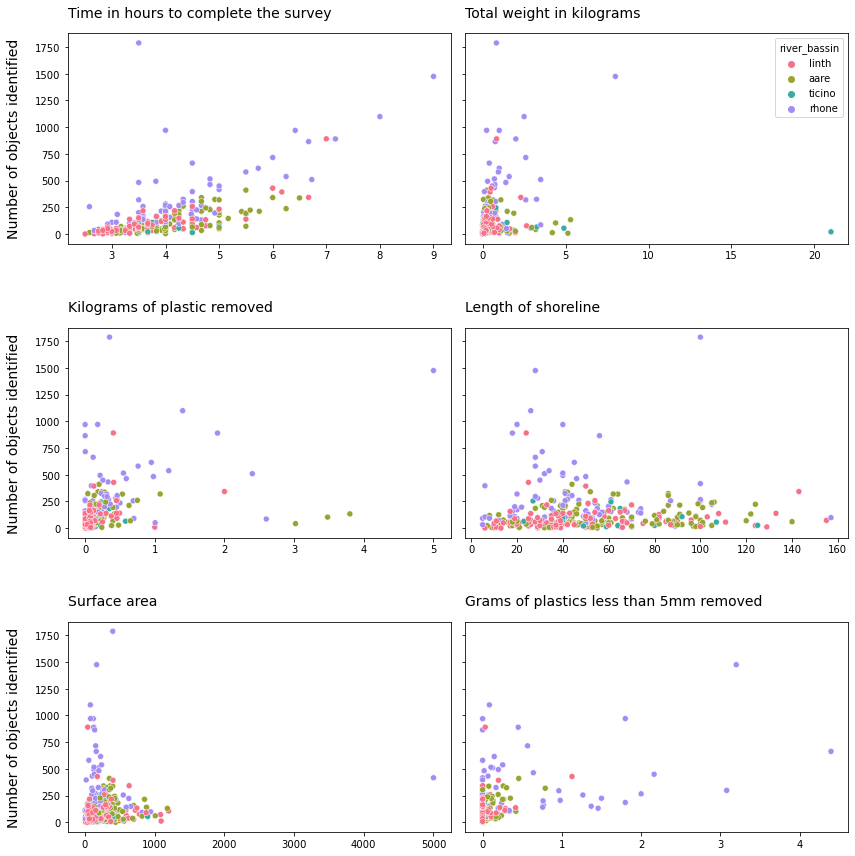

In [11]:
print("\n")
fig, axs = plt.subplots(3,2,figsize=(12,12), sharex=False, sharey=True)
sns.scatterplot(data=som_dims, x='time to survey', y='quantity', hue='river_bassin', palette='husl', ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_title("Time in hours to complete the survey", **title_k14 )
axs[0,0].set_xlabel("")
axs[0,0].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims[som_dims['total weight'] < 50], x='total weight', y='quantity', hue='river_bassin', palette='husl', ax=axs[0,1])

axs[0,1].set_title("Total weight in kilograms", **title_k14 )
axs[0,1].set_xlabel("" )
axs[0,1].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims[som_dims['total weight'] < 50], x=som_dims[som_dims['total weight'] < 50]['plastic > 5mm weight']/1000, y='quantity', hue='river_bassin', palette='husl', ax=axs[1,0])
axs[1,0].get_legend().remove()
axs[1,0].set_title("Kilograms of plastic removed", **title_k14 )
axs[1,0].set_xlabel("" )
axs[1,0].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims, x='meters surveyed', y='quantity', hue='river_bassin', palette='husl', ax=axs[1,1])
axs[1,1].get_legend().remove()
axs[1,1].set_title("Length of shoreline", **title_k14 )
axs[1,1].set_xlabel("")
axs[1,1].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims, x='m² surveyed', y='quantity', hue='river_bassin', palette='husl', ax=axs[2,0])
axs[2,0].get_legend().remove()
axs[2,0].set_title("Surface area", **title_k14 )
axs[2,0].set_xlabel("")
axs[2,0].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims[som_dims['plastic < 5mm weight'] < 10], x=som_dims[som_dims['plastic < 5mm weight'] < 10]['plastic < 5mm weight'], y='quantity', hue='river_bassin', palette='husl', ax=axs[2,1])
axs[2,1].get_legend().remove()
axs[2,1].set_title("Grams of plastics less than 5mm removed", **title_k14 )
axs[2,1].set_xlabel("")
axs[2,1].set_ylabel("Number of objects identified", **xlab_k14)

plt.subplots_adjust(hspace=.5)

plt.tight_layout()
plt.subplots_adjust(hspace=.4)
plt.show()

#### Have a great day

This project was made possible by the Swiss federal office for the environment.

In [12]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
print(F"\nProduced by: {author}\nDate: {today}\n\n{my_message}")


Produced by: roger@hammerdirt.ch
Date: 2021-04-23

Statistics is fun when you do it outside
